## Mutual Info Score - Feature Selection

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
s = df.isna().sum()
s[s>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

## Seperate X and Y Features

In [6]:
X = df.drop(columns=['PassengerId', 'Name', 'Cabin','Ticket', 'Survived'])
Y = df[['Survived']]

In [7]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


## Seperate cat and con for X

In [9]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [10]:
cat

['Sex', 'Embarked']

In [11]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

## Feature Selection Pipeline
1. Use Ordinal encoding for Categorical features

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [13]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [15]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ord', OrdinalEncoder())])

In [16]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [17]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord', OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [18]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


## Perform feature selection with mutual information scores

In [65]:
from sklearn.feature_selection import mutual_info_classif
mc = mutual_info_classif(X_pre, Y)
mc

array([0.09970815, 0.00108838, 0.        , 0.02338843, 0.11915992,
       0.15732122, 0.02056004])

In [66]:
mi = pd.Series(mc)
mi.index = X_pre.columns
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.157321
num__Fare        0.119160
num__Pclass      0.099708
num__Parch       0.023388
cat__Embarked    0.020560
num__Age         0.001088
num__SibSp       0.000000
dtype: float64

<Axes: title={'center': 'Feature Selection'}>

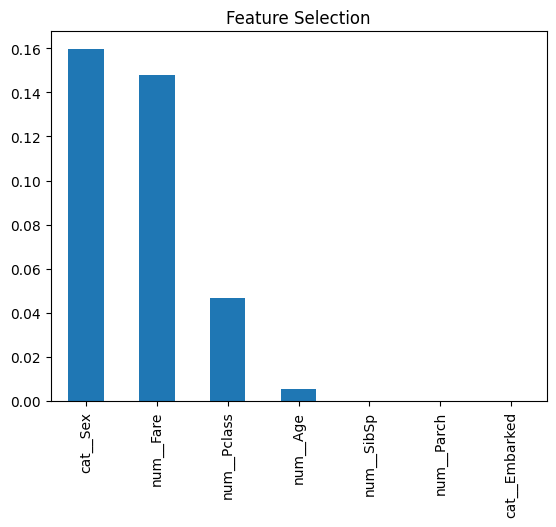

In [23]:
mi.plot(kind='bar', title='Feature Selection')

## Select top 4 features

In [67]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel.fit(X_pre, Y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Age', 'num__SibSp', 'num__Fare', 'cat__Sex'],
      dtype=object)

## Get original columns name out

In [68]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [69]:
imp_cols

['Pclass', 'Age', 'SibSp', 'Fare', 'Sex']

In [70]:
X_imp = X[imp_cols]

In [71]:
X_imp

,Pclass,Age,SibSp,Fare,Sex
0,3,22.0,1,7.2500,male
1,1,38.0,1,71.2833,female
2,3,26.0,0,7.9250,female
3,1,35.0,1,53.1000,female
4,3,35.0,0,8.0500,male
...,...,...,...,...,...
886,2,27.0,0,13.0000,male
887,1,19.0,0,30.0000,female
888,3,NaN,1,23.4500,female
889,1,26.0,0,30.0000,male


## Sepearte cat and con for X_sel

In [72]:
cat_sel = list(X_imp.columns[X_imp.dtypes=='object'])
con_sel = list(X_imp.columns[X_imp.dtypes!='object'])

In [73]:
cat_sel

['Sex']

In [74]:
con_sel

['Pclass', 'Age', 'SibSp', 'Fare']

## Create a Final Pipeline

In [75]:
from sklearn.preprocessing import OneHotEncoder

In [76]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre1 = ColumnTransformer([('num', num_pipe1, con_sel),
                          ('cat', cat_pipe1, cat_sel)]).set_output(transform='pandas')


In [77]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex'])])

In [78]:
X_sel_pre = pre1.fit_transform(X_imp)
X_sel_pre

,num__Pclass,num__Age,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,-0.565736,0.432793,-0.502445,0.0,1.0
1,-1.566107,0.663861,0.432793,0.786845,1.0,0.0
2,0.827377,-0.258337,-0.474545,-0.488854,1.0,0.0
3,-1.566107,0.433312,0.432793,0.420730,1.0,0.0
4,0.827377,0.433312,-0.474545,-0.486337,0.0,1.0
...,...,...,...,...,...,...
886,-0.369365,-0.181487,-0.474545,-0.386671,0.0,1.0
887,-1.566107,-0.796286,-0.474545,-0.044381,1.0,0.0
888,0.827377,-0.104637,0.432793,-0.176263,1.0,0.0
889,-1.566107,-0.258337,-0.474545,-0.044381,0.0,1.0


## Apply train and test split

In [79]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_sel_pre, Y, test_size=0.2, random_state=42)

In [80]:
xtrain.shape

(712, 6)

In [81]:
xtest.shape

(179, 6)

## Create a Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [83]:
model.score(xtrain, ytrain)

0.797752808988764

In [84]:
model.score(xtest, ytest)

0.7932960893854749

In [85]:
ypred_tr = model.predict(xtrain)
ypred_ts = model.predict(xtest)

In [86]:
ypred_tr[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [87]:
ytrain.head()

,Survived
331,0
733,0
382,0
704,0
813,0


In [88]:
ypred_ts[0:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [89]:
ytest.head()

,Survived
709,1
439,0
840,0
720,1
39,1


In [91]:
c = model.classes_
c

array([0, 1], dtype=int64)

## Create confusion matrix

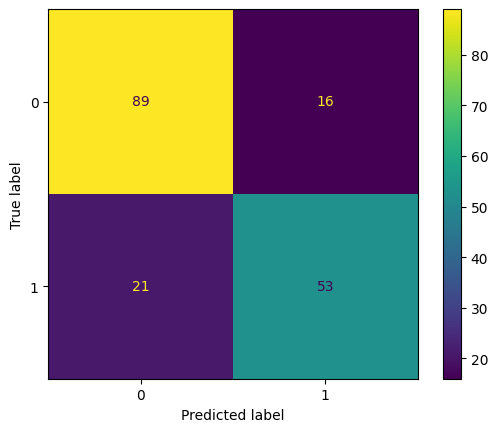

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

## Display classification report

In [93]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



## Predict out of sample data

In [94]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [95]:
xnew_pre = pre1.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Fare,cat__Sex_female,cat__Sex_male
0,0.827377,0.394887,-0.474545,-0.490783,0.0,1.0
1,0.827377,1.355510,0.432793,-0.507479,1.0,0.0
2,-0.369365,2.508257,-0.474545,-0.453367,0.0,1.0
3,0.827377,-0.181487,-0.474545,-0.474005,0.0,1.0
4,0.827377,-0.565736,0.432793,-0.401017,1.0,0.0


In [96]:
pred = model.predict(xnew_pre)
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [98]:
prob = model.predict_proba(xnew_pre)
prob

array([[0.90529134, 0.09470866],
       [0.59102844, 0.40897156],
       [0.89514913, 0.10485087],
       [0.88331854, 0.11668146],
       [0.39743288, 0.60256712],
       [0.83513504, 0.16486496],
       [0.37611105, 0.62388895],
       [0.79107932, 0.20892068],
       [0.29434271, 0.70565729],
       [0.92376717, 0.07623283],
       [0.88666966, 0.11333034],
       [0.65744448, 0.34255552],
       [0.07658152, 0.92341848],
       [0.92264626, 0.07735374],
       [0.15551942, 0.84448058],
       [0.20552428, 0.79447572],
       [0.786814  , 0.213186  ],
       [0.86336781, 0.13663219],
       [0.43780921, 0.56219079],
       [0.48920425, 0.51079575],
       [0.76581941, 0.23418059],
       [0.81539644, 0.18460356],
       [0.07285446, 0.92714554],
       [0.44606978, 0.55393022],
       [0.09766279, 0.90233721],
       [0.95543336, 0.04456664],
       [0.05662447, 0.94337553],
       [0.86872418, 0.13127582],
       [0.61902865, 0.38097135],
       [0.93802614, 0.06197386],
       [0.

In [99]:
import numpy as np
prob_max = np.max(prob, axis=1)
prob_max

array([0.90529134, 0.59102844, 0.89514913, 0.88331854, 0.60256712,
       0.83513504, 0.62388895, 0.79107932, 0.70565729, 0.92376717,
       0.88666966, 0.65744448, 0.92341848, 0.92264626, 0.84448058,
       0.79447572, 0.786814  , 0.86336781, 0.56219079, 0.51079575,
       0.76581941, 0.81539644, 0.92714554, 0.55393022, 0.90233721,
       0.95543336, 0.94337553, 0.86872418, 0.61902865, 0.93802614,
       0.88881143, 0.83370245, 0.52515476, 0.56529051, 0.60344754,
       0.85403123, 0.63849388, 0.68697975, 0.8765685 , 0.87228793,
       0.91531784, 0.52404822, 0.92110767, 0.81388894, 0.84933917,
       0.87704396, 0.64812361, 0.8867106 , 0.84332902, 0.58528205,
       0.55696539, 0.74116858, 0.75266059, 0.89496447, 0.74674182,
       0.94482837, 0.90658709, 0.87712681, 0.91555633, 0.94988844,
       0.84794007, 0.7703448 , 0.8519184 , 0.67975199, 0.58082226,
       0.8262683 , 0.70603446, 0.65404727, 0.5456392 , 0.8648066 ,
       0.66621892, 0.86314651, 0.63127703, 0.52707035, 0.94431

In [100]:
xnew['survied_pred'] = pred
xnew['survived_prob'] = prob_max

In [101]:
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,survied_pred,survived_prob
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.905291
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0.591028
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.895149
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.883319
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.602567


## Save above result into CSV file

In [102]:
xnew.to_csv('Result_mutual_info.csv', index=False)